# Clifford Quantum Cellular Automata
A Clifford Quantum Cellular Automaton (CQCA) is a *globally unique* ruleset for mapping Pauli gates to a set of Pauli gates.
This ruleset is applied, at each time step, to every cell of an infinite lattice.
Each cell holds a Pauli gate.

The application of a gate to another follows following rules:
- $i \times i = I, i \in \{I, X, Y, Z\}$ (Unitary operator)
- $i \times I = I \times i = i, i \in \{I, X, Y, Z\}$ (Identity is neutral)
- $i \times j = k, i \neq j \neq k \in \{X, Y, Z\}$

Initially, all cells of the lattice are identity gates.
However, one can change some of the cells before the first iteration to form a starting configuration.
By then iterating over time steps, the configuration of the lattice changes.
The patterns in the change are discussed in this notebook.

In this notebook, the lattice is always 1-dimensional (i.e., a spin chain).

## Environment Preparation
Technical necessities for the notebook to work properly.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from util import list_to_str, plot_entanglement
from model.automaton import Automaton
from model.lattice import Lattice
from model.gate import Identity, PauliX, PauliY, PauliZ

## Rulesets
Rules are specified by mapping gates to a list of gates.
For each cell, the corresponding rule is applied to the cell itself, as well as its neighborhood.

The rules are encoded as matrices of Laurent polynomials. TODO

In [3]:
glider = Automaton([[[], [0]], [[0], [-1, 1]]])

### Evolution of a Pauli Z Gate
A cell containing a Z gate will contain an X gate in the next time step, and also apply a Z gate to the surrounding cells.

In [4]:
lattice = Lattice([PauliZ()], glider)

res = lattice.iterate(5)

for cells, _ in res:
    print(list_to_str(cells))

					1Z					
				1Z	1X	1Z				
			1Z	1X	1Z	1X	1Z			
		1Z	1X	1Z	1X	1Z	1X	1Z		
	1Z	1X	1Z	1X	1Z	1X	1Z	1X	1Z	
1Z	1X	1Z	1X	1Z	1X	1Z	1X	1Z	1X	1Z


### Evolution of a Pauli X Gate.
An X gate will become a Z gate.
The neighborhood is unchanged.
From the second timestep forward the lattice behaves as if it had started with a Z gate.

In [5]:
lattice = Lattice([PauliX()], glider)

res = lattice.iterate(5)

for cells, _ in res:
    print(list_to_str(cells))

				1X				
				1Z				
			1Z	1X	1Z			
		1Z	1X	1Z	1X	1Z		
	1Z	1X	1Z	1X	1Z	1X	1Z	
1Z	1X	1Z	1X	1Z	1X	1Z	1X	1Z


### Glider
Since quantum gates, especially Pauli gates, are unitary, they are able to cancel each other out into identity gates. With the right configuration, the "active" gates (i.e., those, which are not the identity gates) propagate to a certain direction, leaving behind only "inactive" identity gates.

**Example:** Starting with Pauli X and Z gates next to each other produces a basic glider.

In [6]:
lattice = Lattice([PauliX(), PauliZ()], glider)

res = lattice.iterate(5)

for cells, _ in res:
    print(list_to_str(cells))

1X	1Z					
	1X	1Z				
		1X	1Z			
			1X	1Z		
				1X	1Z	
					1X	1Z


## Fractal Behavior
The following configuration exhibits a fractal behavior.

In [7]:
fractal = Automaton([[[-1, 0, 1], [0]], [[0], []]])

In [8]:
lattice = Lattice([PauliX(), PauliY(), PauliZ(), PauliY(), PauliX()], fractal)

res = lattice.iterate(5)

for cells, _ in res:
    print(list_to_str(cells))

					1X	1Y	1Z	1Y	1X					
				1X	1Z	1Y	1X	1Y	1Z	1X				
			1X	1Y	1X	1Y	1Y	1Y	1X	1Y	1X			
		1X	1Z	1Z	1Y	1Z	1Z	1Z	1Y	1Z	1Z	1X		
	1X	1Y			1Z		1X		1Z			1Y	1X	
1X	1Z	1Y	1X		1X	1X	1Y	1X	1X		1X	1Y	1Z	1X


## Entanglement
When the initial cells are entangled, their "reach", which may be increasing over time, entangles further cells. TODO

In [9]:
glider2 = Automaton([[[], [0]], [[0], [-2, 2]]])

In [10]:
alms = [
    (glider, "Glider", "v"),
    (glider2, "Glider (length 2)", "^"),
    (fractal, "Fractal", "x"),
    #(periodical, "Periodical", "s")
]
init_config = [PauliY(), PauliX(), PauliY()]
max_t = 20

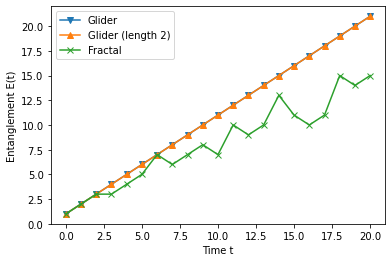

In [11]:
plot_entanglement(alms, init_config, max_t)